# Data Validation & Documentation

In [7]:
# Step 1: Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import os
from PIL import Image
import warnings
import json
from collections import defaultdict
import sys

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

# Reuse paths from Week 2
DATA_PATH = Path("../data")
PROCESSED_PATH = DATA_PATH / "processed/metadata"

# Image Configuration (same as before)
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 15

# Label columns
LABEL_COLUMNS = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
    'Infiltration', 'Mass', 'No Finding', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.20.0
GPU Available: []


# Step 2: Load preprocessed data

In [9]:
def load_preprocessed_data():
    
    train_df = pd.read_csv(PROCESSED_PATH / "nih_train_data.csv")
    val_df = pd.read_csv(PROCESSED_PATH / "nih_val_data.csv")
    test_df = pd.read_csv(PROCESSED_PATH / "nih_test_data.csv")

    print(f"Train samples: {len(train_df):,}")
    print(f"Validation samples: {len(val_df):,}")
    print(f"Test samples: {len(test_df):,}")

    return train_df, val_df, test_df

train_df, val_df, test_df = load_preprocessed_data()

Train samples: 69,219
Validation samples: 17,305
Test samples: 25,596


# Step 3: Data Validation – Check for Data Leakage

In [10]:
def check_data_leakage(df1, df2, col='full_path'):
    """
    Check if any image appears in both df1 and df2.
    """
    set1 = set(df1[col].tolist())
    set2 = set(df2[col].tolist())
    overlap = set1.intersection(set2)

    if len(overlap) > 0:
        print(f"WARNING: {len(overlap)} overlapping images found!")
        print("Sample overlapping paths:", list(overlap)[:3])
        return False
    else:
        print("No data leakage detected.")
        return True

# Check between splits
print("\nChecking train-val overlap...")
check_data_leakage(train_df, val_df)

print("\nChecking train-test overlap...")
check_data_leakage(train_df, test_df)

print("\nChecking val-test overlap...")
check_data_leakage(val_df, test_df)


Checking train-val overlap...
No data leakage detected.

Checking train-test overlap...
No data leakage detected.

Checking val-test overlap...
No data leakage detected.


True

# Step 4: Prepare Data Statistics Report

In [11]:
print("DATA STATISTICS REPORT")

# 4.1 Samples per class in each split
def samples_per_class(df, split_name):
    """
    Calculate number of samples per class for a given split.
    """
    class_counts = {}
    for col in LABEL_COLUMNS:
        class_counts[col] = df[col].sum()

    return pd.Series(class_counts, name=split_name)

train_counts = samples_per_class(train_df, "Train")
val_counts = samples_per_class(val_df, "Validation")
test_counts = samples_per_class(test_df, "Test")

# Combine into a single DataFrame
counts_df = pd.concat([train_counts, val_counts, test_counts], axis=1)
print("\n1. Samples per class in each split:")
print(counts_df)

# 4.2 Train/val/test counts (already printed, but let's show again)
print("\n2. Total samples per split:")
print(f"   Train: {len(train_df):,}")
print(f"   Validation: {len(val_df):,}")
print(f"   Test: {len(test_df):,}")

# 4.3 Image size distribution (original images)
print("\n3. Checking original image size distribution...")

def get_image_sizes(df, sample_size=100):
    """
    Get width and height of a sample of images.
    """
    widths, heights = [], []
    sampled_paths = df['full_path'].sample(min(sample_size, len(df)), random_state=42)

    for path in sampled_paths:
        if not os.path.exists(path):
            continue
        try:
            with Image.open(path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
        except:
            continue

    return widths, heights

# Sample from each split
train_widths, train_heights = get_image_sizes(train_df)
val_widths, val_heights = get_image_sizes(val_df)
test_widths, test_heights = get_image_sizes(test_df)

print(f"   Sampled {len(train_widths)} train images.")
print(f"   Sampled {len(val_widths)} validation images.")
print(f"   Sampled {len(test_widths)} test images.")

DATA STATISTICS REPORT

1. Samples per class in each split:
                    Train  Validation  Test
Atelectasis          6640        1640  3279
Cardiomegaly         1366         341  1069
Consolidation        2266         586  1815
Edema                1115         263   925
Effusion             6993        1666  4658
Emphysema            1133         290  1093
Fibrosis              992         259   435
Hernia                112          29    86
Infiltration        11037        2745  6112
Mass                 3258         776  1748
No Finding          40411       10089  9861
Nodule               3743         965  1623
Pleural_Thickening   1800         442  1143
Pneumonia             692         184   555
Pneumothorax         2085         552  2665

2. Total samples per split:
   Train: 69,219
   Validation: 17,305
   Test: 25,596

3. Checking original image size distribution...
   Sampled 100 train images.
   Sampled 100 validation images.
   Sampled 100 test images.


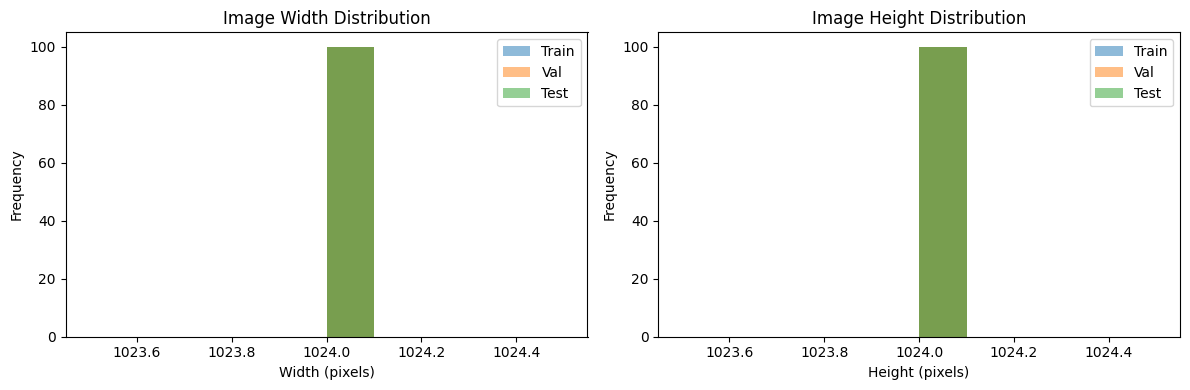

In [12]:
# Plot image size distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(train_widths, alpha=0.5, label='Train')
axes[0].hist(val_widths, alpha=0.5, label='Val')
axes[0].hist(test_widths, alpha=0.5, label='Test')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Width Distribution')
axes[0].legend()

axes[1].hist(train_heights, alpha=0.5, label='Train')
axes[1].hist(val_heights, alpha=0.5, label='Val')
axes[1].hist(test_heights, alpha=0.5, label='Test')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Height Distribution')
axes[1].legend()

plt.tight_layout()
plt.savefig(PROCESSED_PATH / "image_size_distribution.png", dpi=150)
plt.show()

In [13]:
# 4.4 Multi-label statistics
print("\n4. Multi-label statistics:")
for df_name, df in zip(['Train', 'Validation', 'Test'], [train_df, val_df, test_df]):
    num_labels_per_image = df['num_labels'].value_counts().sort_index()
    print(f"\n   {df_name} set:")
    for num_labels, count in num_labels_per_image.items():
        percentage = (count / len(df)) * 100
        print(f"      {num_labels} label(s): {count:,} images ({percentage:.1f}%)")


4. Multi-label statistics:

   Train set:
      1 label(s): 58,769 images (84.9%)
      2 label(s): 7,391 images (10.7%)
      3 label(s): 2,354 images (3.4%)
      4 label(s): 544 images (0.8%)
      5 label(s): 121 images (0.2%)
      6 label(s): 33 images (0.0%)
      7 label(s): 6 images (0.0%)
      9 label(s): 1 images (0.0%)

   Validation set:
      1 label(s): 14,702 images (85.0%)
      2 label(s): 1,894 images (10.9%)
      3 label(s): 544 images (3.1%)
      4 label(s): 131 images (0.8%)
      5 label(s): 28 images (0.2%)
      6 label(s): 3 images (0.0%)
      7 label(s): 2 images (0.0%)
      9 label(s): 1 images (0.0%)

   Test set:
      1 label(s): 17,853 images (69.7%)
      2 label(s): 5,021 images (19.6%)
      3 label(s): 1,958 images (7.6%)
      4 label(s): 572 images (2.2%)
      5 label(s): 152 images (0.6%)
      6 label(s): 31 images (0.1%)
      7 label(s): 8 images (0.0%)
      8 label(s): 1 images (0.0%)


# Step 5: Package Data Pipeline as Reusable Modules

In [15]:
# 5.1 Create a module directory
module_dir = Path("modules")
module_dir.mkdir(exist_ok=True)

In [16]:
# 5.2 Save the data loading function
data_loader_code = '''
import pandas as pd
from pathlib import Path

def load_nih_splits(data_path="../data"):
    """
    Load NIH Chest X-ray train/val/test splits.

    Parameters:
    -----------
    data_path : str or Path
        Path to the main data directory

    Returns:
    --------
    train_df, val_df, test_df : pandas DataFrames
        DataFrames containing image paths and labels
    """
    processed_path = Path(data_path) / "processed/metadata"

    train_df = pd.read_csv(processed_path / "nih_train_data.csv")
    val_df = pd.read_csv(processed_path / "nih_val_data.csv")
    test_df = pd.read_csv(processed_path / "nih_test_data.csv")

    return train_df, val_df, test_df

LABEL_COLUMNS = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
    'Infiltration', 'Mass', 'No Finding', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]
'''

with open(module_dir / "data_loader.py", "w") as f:
    f.write(data_loader_code)

In [17]:
# 5.3 Save the image preprocessing function
preprocessor_code = '''
import cv2
import numpy as np

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image for model input.

    Parameters:
    -----------
    image_path : str
        Path to the image file
    target_size : tuple
        (height, width) to resize the image

    Returns:
    --------
    img : numpy array
        Preprocessed image normalized to [0, 1]
    """
    try:
        # Load image
        img = cv2.imread(image_path)

        if img is None:
            raise ValueError(f"Could not load image at {image_path}")

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to target size
        img = cv2.resize(img, target_size)

        # Normalize to [0, 1] range
        img = img.astype(np.float32) / 255.0

        return img

    except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        return None

def create_tf_dataset(df, image_dir="", target_size=(224, 224),
                      batch_size=32, shuffle=True, augment=False):
    """
    Create a TensorFlow dataset from a DataFrame.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with 'full_path' and label columns
    target_size : tuple
        Target image size
    batch_size : int
        Batch size
    shuffle : bool
        Whether to shuffle the dataset
    augment : bool
        Whether to apply data augmentation

    Returns:
    --------
    dataset : tf.data.Dataset
        TensorFlow dataset
    """
    import tensorflow as tf

    # Data augmentation
    if augment:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
    else:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    # Create dataset
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_dir,  # This would need adjustment for NIH dataset structure
        labels=df[LABEL_COLUMNS].values,
        batch_size=batch_size,
        image_size=target_size,
        shuffle=shuffle
    )

    return dataset
'''

with open(module_dir / "image_preprocessor.py", "w") as f:
    f.write(preprocessor_code)

In [19]:
# 5.4 Save the validation functions
validator_code = '''
import pandas as pd

def check_data_leakage(df1, df2, col='full_path'):
    """
    Check if any image appears in both df1 and df2.

    Parameters:
    -----------
    df1, df2 : pandas DataFrames
        DataFrames to compare
    col : str
        Column name to check for duplicates

    Returns:
    --------
    bool : True if no leakage, False if leakage detected
    """
    set1 = set(df1[col].tolist())
    set2 = set(df2[col].tolist())
    overlap = set1.intersection(set2)

    if len(overlap) > 0:
        print(f" WARNING: {len(overlap)} overlapping images found!")
        return False
    else:
        print("No data leakage detected.")
        return True

def get_data_statistics(df, split_name):
    """
    Generate statistics for a dataset split.

    Parameters:
    -----------
    df : pandas DataFrame
        Dataset to analyze
    split_name : str
        Name of the split (for reporting)

    Returns:
    --------
    dict : Dictionary containing statistics
    """
    from collections import Counter

    stats = {
        'split_name': split_name,
        'total_samples': len(df),
        'samples_per_class': {},
        'multi_label_distribution': dict(Counter(df['num_labels'])),
        'avg_labels_per_image': df['num_labels'].mean()
    }

    # Count per class
    for col in LABEL_COLUMNS:
        stats['samples_per_class'][col] = int(df[col].sum())

    return stats
'''

with open(module_dir / "data_validator.py", "w") as f:
    f.write(validator_code)


In [20]:
# 5.5 Create a main module that ties everything together
main_module_code = '''
"""
NIH Chest X-ray Data Pipeline Module
====================================

This module provides a complete pipeline for loading, preprocessing,
and validating the NIH Chest X-ray dataset.

Usage:
------
>>> from modules.data_loader import load_nih_splits
>>> from modules.image_preprocessor import load_and_preprocess_image
>>> from modules.data_validator import check_data_leakage

>>> # Load data
>>> train_df, val_df, test_df = load_nih_splits()
>>>
>>> # Check for data leakage
>>> check_data_leakage(train_df, val_df)
>>>
>>> # Preprocess an image
>>> img = load_and_preprocess_image(train_df.iloc[0]['full_path'])
"""

__version__ = "1.0.0"
__author__ = "NIH Image Processing Team"

# Export main functions
from .data_loader import load_nih_splits, LABEL_COLUMNS
from .image_preprocessor import load_and_preprocess_image, create_tf_dataset
from .data_validator import check_data_leakage, get_data_statistics

__all__ = [
    'load_nih_splits',
    'LABEL_COLUMNS',
    'load_and_preprocess_image',
    'create_tf_dataset',
    'check_data_leakage',
    'get_data_statistics'
]
'''

with open(module_dir / "__init__.py", "w") as f:
    f.write(main_module_code)


In [21]:
print("Created reusable modules in 'modules/' directory:")

Created reusable modules in 'modules/' directory:


# Step 6: Generate Final Documentation Report

In [23]:
# Create a comprehensive report
report = {
    "dataset_name": "NIH Chest X-ray",
    "num_classes": NUM_CLASSES,
    "label_columns": LABEL_COLUMNS,
    "splits": {
        "train": {
            "samples": int(len(train_df)),
            "samples_per_class": train_counts.astype(int).to_dict()
        },
        "validation": {
            "samples": int(len(val_df)),
            "samples_per_class": val_counts.astype(int).to_dict()
        },
        "test": {
            "samples": int(len(test_df)),
            "samples_per_class": test_counts.astype(int).to_dict()
        }
    },
    "image_configuration": {
        "target_size": [IMG_SIZE, IMG_SIZE],
        "batch_size": BATCH_SIZE,
        "normalization": "[0, 1] range"
    },
    "data_leakage_check": {
        "train_val_overlap": int(len(set(train_df['full_path']).intersection(set(val_df['full_path'])))),
        "train_test_overlap": int(len(set(train_df['full_path']).intersection(set(test_df['full_path'])))),
        "val_test_overlap": int(len(set(val_df['full_path']).intersection(set(test_df['full_path']))))
    },
    "multi_label_info": {
        "train": {k: int(v) for k, v in train_df['num_labels'].value_counts().items()},
        "validation": {k: int(v) for k, v in val_df['num_labels'].value_counts().items()},
        "test": {k: int(v) for k, v in test_df['num_labels'].value_counts().items()}
    },
    "pipeline_info": {
        "modules_created": ["data_loader.py", "image_preprocessor.py", "data_validator.py"],
        "handoff_ready": True,
        "notes": "All images resized to 224x224, normalized to [0,1]"
    }
}

# Save report as JSON
report_path = PROCESSED_PATH / "data_pipeline_report.json"
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"Data documentation saved to: {report_path}")

Data documentation saved to: ..\data\processed\metadata\data_pipeline_report.json


# Step 7: Handoff Preparation

In [26]:
# 7.2 Create a README for the handoff
readme = """
NIH CHEST X-RAY DATA PIPELINE
=============================

Overview
--------
This pipeline loads, preprocesses, and validates the NIH Chest X-ray dataset
for multi-label classification of 15 thoracic diseases.

Dataset Structure
-----------------
- Train: 69,219 images
- Validation: 17,305 images
- Test: 25,596 images
- Total: 112,120 images

Classes (15):
-------------
Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema,
Fibrosis, Hernia, Infiltration, Mass, No Finding, Nodule,
Pleural_Thickening, Pneumonia, Pneumothorax

Pipeline Modules
----------------
1. `data_loader.py` - Load train/val/test splits
2. `image_preprocessor.py` - Image loading and preprocessing
3. `data_validator.py` - Data leakage checks and statistics

Usage Example
-------------
```python
# Import modules
from modules.data_loader import load_nih_splits
from modules.image_preprocessor import load_and_preprocess_image
from modules.data_validator import check_data_leakage

# Load data
train_df, val_df, test_df = load_nih_splits()

# Check for data leakage
check_data_leakage(train_df, val_df)

# Preprocess an image
img = load_and_preprocess_image(train_df.iloc[0]['full_path'])
    """

with open("HANDOFF_README.md", "w") as f:
  f.write(readme)

print("Created handoff documents.")

Created handoff documents.


In [27]:
print("READY FOR HANDOFF")
print("\nThe clean, validated dataset is ready for model development.")
print("All modules are in the 'modules/' directory.")

READY FOR HANDOFF

The clean, validated dataset is ready for model development.
All modules are in the 'modules/' directory.
